In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import tensorflow as tf
import shap
tf.compat.v1.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 200
data = pd.read_csv('clean_pan.csv', index_col='CASEID')
data = data.drop(['Unnamed: 0'], axis=1)


In [5]:
cat_names = ['PAN_JAUNDICE', 'PAN_BILIARYSTENT', 'PAN_CHEMO', 'PAN_RADIO', 'PAN_INTRA_ANTIBIOTICS',  'PAN_DUCTSIZE', 'PAN_GLANDTEXT', 'PAN_RECONSTRUCTION',  'PAN_DRAINS', 'PAN_DRAINS_TYPE', 'PAN_DRAINSYS_TYPE', 'PAN_DRAINSYS_SUCTN', 'PAN_RESECTION', 
            ]
cont_names = ['PAN_AMYLASE_POD1']
y_names=['PAN_FISTULA']

features = cat_names + cont_names + y_names
data = data[features]

columns = {'PAN_JAUNDICE':'Jaundice', 'PAN_BILIARYSTENT':'Biliary stent', 'PAN_CHEMO':'Chemotherapy', 'PAN_RADIO':'Radiation therapy', 'PAN_INTRA_ANTIBIOTICS':'Antibiotic',  'PAN_DUCTSIZE':'Duct size', 'PAN_GLANDTEXT':'Gland texture', 'PAN_RECONSTRUCTION':'Reconstruction',  'PAN_DRAINS':'Drains', 'PAN_DRAINS_TYPE':'Drain location', 'PAN_DRAINSYS_TYPE':'Drain type', 'PAN_DRAINSYS_SUCTN':'Drain suction', 'PAN_RESECTION':'Vascular resection','PAN_AMYLASE_POD1':'Drain amylase (POD1)'}


col = {value : key for key, value in columns.items()}


In [7]:
data.rename(columns=columns, errors='raise', inplace=True)

In [9]:
X = data.drop(['PAN_FISTULA'], axis=1)
y = data['PAN_FISTULA']

In [10]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)


In [13]:
input_shape = [X.shape[1]]
model4 = tf.keras.models.Sequential()
model4.add(tf.keras.layers.Flatten(input_shape=input_shape))
model4.add(tf.keras.layers.BatchNormalization())
for _ in range(2):
    model4.add(tf.keras.layers.Dense(1000))
    model4.add(tf.keras.layers.BatchNormalization())
    model4.add(tf.keras.layers.Dropout(0.8))
    model4.add(tf.keras.layers.Activation("relu"))
model4.add(tf.keras.layers.Dense(1, activation="sigmoid"))

opt = tf.keras.optimizers.Adam(learning_rate=3e-4)

metrics = [tf.keras.metrics.Recall(name='Sensitivity'), tf.keras.metrics.TrueNegatives(name='tn'), tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.AUC(name='prc', curve='PR')]

model4.compile(
    optimizer=opt,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics,)

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.00001,
    restore_best_weights=True,)
model4.fit(X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=1024,
    epochs=200,
    callbacks=[early_stopping])


Train on 18586 samples, validate on 4647 samples
Epoch 1/200
18586/18586 [==============================] - 1s 39us/sample - loss: 0.7432 - Sensitivity: 0.2586 - tn: 11896.0000 - auc: 0.5340 - prc: 0.1800 - val_loss: 0.5651 - val_Sensitivity: 0.1257 - val_tn: 3790.0000 - val_auc: 0.6749 - val_prc: 0.2958
Epoch 2/200
18586/18586 [==============================] - 0s 10us/sample - loss: 0.6228 - Sensitivity: 0.1485 - tn: 14161.0000 - auc: 0.5856 - prc: 0.2219 - val_loss: 0.5546 - val_Sensitivity: 0.1297 - val_tn: 3783.0000 - val_auc: 0.6782 - val_prc: 0.2973
Epoch 3/200
18586/18586 [==============================] - 0s 11us/sample - loss: 0.6104 - Sensitivity: 0.1420 - tn: 14214.0000 - auc: 0.6015 - prc: 0.2274 - val_loss: 0.5444 - val_Sensitivity: 0.1136 - val_tn: 3797.0000 - val_auc: 0.6804 - val_prc: 0.2972
Epoch 4/200
18586/18586 [==============================] - 0s 11us/sample - loss: 0.5932 - Sensitivity: 0.1530 - tn: 14211.0000 - auc: 0.6004 - prc: 0.2343 - val_loss: 0.5284 - val

In [14]:
X_train.shape

(18586, 14)

In [15]:
X_valid.shape

(4647, 14)

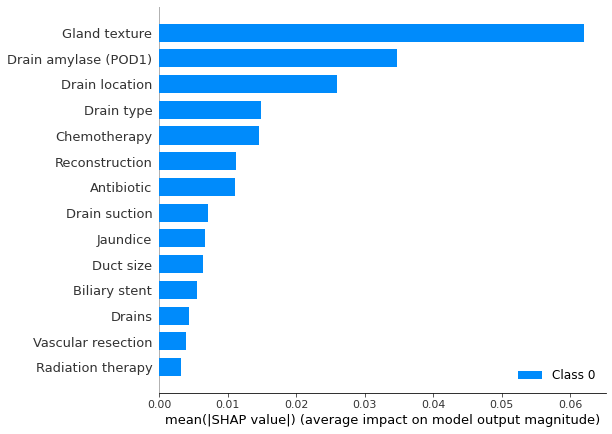

In [16]:


import shap
tf.config.list_physical_devices('GPU')
explainer = shap.DeepExplainer(model4, X_train.sample(n=4000))
shap_values = explainer.shap_values(X_valid.sample(n=4000).values)
shap.summary_plot(shap_values, X_valid.sample(n=4000))